# Workshop 3: Exploring IllustrisTNG simulations to derive observationally comparable star formation rates and metallicities

## Notebook 2: The global star forming main sequence

Created by Bryanne McDonough and Olivia Curtis

In this notebook, we will use the data we pulled from the TNG simulation in Notebook 1 to construct a global star forming main sequence (M_* - SFR) relation, and perform a ridge line fit. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy.ma as ma

### Update this directory! ###
#dirc='/path/to/directory/'
currentdirc=!pwd
print(currentdirc)
#dirc= ' '.join(currentdirc) + '/TNG_workshop_data/'
dirc = ' '.join(currentdirc) + '/backup_data/'
print(f"current dirc {dirc}")
#dirc='/projectnb/res-star/TNG_workshop/'

['/Users/alexpoulin/Downloads/git/TNG/TNG_workshop']
current dirc /Users/alexpoulin/Downloads/git/TNG/TNG_workshop/backup_data/


## Loading the data
First, let's load in the galaxy catalog we generated in the previous notebook.

Recall that we saved the galaxy catalog as a dictionary, so we can print its keys to see 
what data we have to work with.

In [7]:
#loads the dictionary and prints its keys
dat=np.load(dirc+'galcat.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['subID', 'pos', 'M_*', 'SFR_inst', 'SFR_all_10'])


Now, let's grab the variables that we will be working with in this notebook. 

In [8]:
#unpacking stellar mass, instanteous SFRs, and SFRs over the past 10 Myrs
mass= dat['M_*'] #Units M_*
SFR_i = dat['SFR_inst'] #Units M_\odot / yr
SFR_10 = dat['SFR_all_10'] #Units M_\odot /yr

#Feel free to unpack any other variables that you may have saved!

## Plotting the M_* - SFR relation

For now, let's just use the instantaneous SFRs.

Let's start by exploring our data. First, take the log10 of the data

In [9]:
#take the log of mass and SFR
logmass = np.log10(mass)
logSFR = np.log10(SFR_i)

#you should get a runetime warning here, ignore it for now.

/var/folders/9v/hlrr6pv51bv0wc4ddcq4b7d00000gn/T/ipykernel_52086/3952701424.py:3: RuntimeWarning: divide by zero encountered in log10
  logSFR = np.log10(SFR_i)


Next, get the minima, medians, and maxima of each array 

In [10]:
#get and print the stellar mass values
min_logmass = min(logmass)
median_logmass = np.median(logmass)
max_logmass = max(logmass)

print("log10(mass) min:    ", min_logmass)
print("log10(mass) median: ", median_logmass)
print("log10(mass) max:    ", max_logmass)

log10(mass) min:     8.000028533015758
log10(mass) median:  8.820547987312008
log10(mass) max:     12.568856751592588


Let's do the same for the instantaneous star formation rates

In [11]:
#get and print the stellar mass values
min_logSFR = min(logSFR)
median_logSFR = np.median(logSFR)
max_logSFR = max(logSFR)

print("log10(SFR) min:    ", min_logSFR)
print("log10(SFR) median: ", median_logSFR)
print("log10(SFR) max:    ", max_logSFR)

log10(SFR) min:     -inf
log10(SFR) median:  -1.4029273
log10(SFR) max:     1.9992148


**Notice:** Some of the galaxies in our sample have SFR=0. This is due to the minimum baryonic mass of a particle in the simulations. Thus, low amounts of gas and star formation will be unresolved. You can check the minimum baryonic mass for a given simulation in the table here: https://www.tng-project.org/data/docs/background/#sec1

In order to visualize the quenched galaxies on our diagram, you can impose a fixed specific SFR. However, let's stick to the galaxies with resolved star formation.

Now, let's make a 2D histogram of the SFR - M_* plane using matplotlib. We will be using matplotlib.pyplot.hist2d for this, which you can read about here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html

In [12]:
#If you are unsure how to use hist2d,
#then run this block of code to read its 
#documentation in Jupyter
plt.hist2d?

Signature:
plt.hist2d(
    x,
    y,
    bins=10,
    range=None,
    density=False,
    weights=None,
    cmin=None,
    cmax=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Make a 2D histogram plot.

Parameters
----------
x, y : array-like, shape (n, )
    Input values

bins : None or int or [int, int] or array-like or [array, array]

    The bin specification:

    - If int, the number of bins for the two dimensions
      (nx=ny=bins).
    - If ``[int, int]``, the number of bins in each dimension
      (nx, ny = bins).
    - If array-like, the bin edges for the two dimensions
      (x_edges=y_edges=bins).
    - If ``[array, array]``, the bin edges in each dimension
      (x_edges, y_edges = bins).

    The default value is 10.

range : array-like shape(2, 2), optional
    The leftmost and rightmost edges of the bins along each dimension
    (if not specified explicitly in the bins parameters): ``[[xmin,
    xmax], [ymin, ymax]]``. All values outside of this range will be
    

The shape of hist is:  (100, 100)


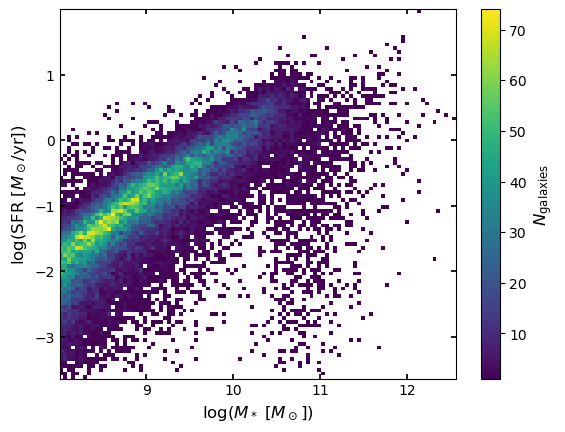

In [13]:
#Call hist 2D. The final histogram, hist, will
#be a 100x100 array containing the number
#of galaxies in each bin.
hist, xedges, yedges, image = plt.hist2d(logmass[np.isfinite(logSFR)], \
                                         logSFR[np.isfinite(logSFR)], \
                                         bins=100, cmin=1)

print("The shape of hist is: ", hist.shape)

#Add a vertical colorbar to the figure and label it
cbar=plt.colorbar()
cbar.set_label('$N_{\mathrm{galaxies}}$', rotation=90, fontsize=12)

#Label the axes
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('log(SFR [$M_\odot$/yr])',fontsize=12)

#Change the style of the tick marks
plt.tick_params(axis='both', direction='in', \
                width=1.25, labelsize='medium', \
                which='both', top=True, right=True)

## Performing a ridge line fit

The most common main sequence fit uses ordinary least squares to fit a line to all the data. But the main sequence isn't exactly linear, and different samples can bias the slope that is obtained. Renzini & Peng (2015) argue that a more objective definition is a so-called 'ridge line' fit: https://ui.adsabs.harvard.edu/abs/2015ApJ...801L..29R/abstract. Functionally, this means we will fit to the mode of the data, or the pixel with the highest count in each mass bin.

That is, for each column in the above figure, we want to find the row that contains the most galaxies. Keep in mind that hist is a 100x100 array, so we will ultimately be saving the midpoints of rows and columns.

Start by instantiating two empty arrays.
The variable fMs will hold the midpoint of each column, 
and fSFR will hold the midpoint of the row that has the most number of galaxies in each column.

In [14]:
#instantiate two empty arrays that we will populate later
#recall that hist is a size 100x100 array.
fMs=np.empty(100)
fSFR=np.empty(100)

Next, let's remove any cells from hist that did not contain any galaxies (i.e., any cells whose value is NaN). 

In [ ]:
#find all NaN cells in hist
mask=np.isnan(hist)
#mask out the invalid cells
goodhist=ma.masked_array(hist, mask=mask)

Let's print hist and goodhist to verify the mask did what we want.

In [16]:
print(hist)
print("\n")
print(goodhist)

[[nan  1.  1. ... nan nan nan]
 [ 1.  2. nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


[[-- 1.0 1.0 ... -- -- --]
 [1.0 2.0 -- ... -- -- --]
 [-- -- 1.0 ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


Notice that goodhist is still a 100x100 array

In [17]:
print(goodhist.shape)

(100, 100)


Next, we will loop over each column in the histogram. We will find the pixel in each column that contains the most number of galaxies, saving the midpoints of the pixel into fMs and fSFR.

We will thus find the (M_s,SFR) points where histogram is maxed.
Recall that we defined xedges and yedges when we called hist2d.
Here, xedges contains the values of the bin edges along the 
x-axis (i.e., log(Ms)), and yedges contains the
values of the bin edges along the y-axis
(i.e., log(SFR)).

In [18]:
"""
pseudo code for the loop:

for each column do:

    save the midpoint of the column

    find the index of the row 
    that contains the most galaxies,
    call it hmax
    
    save the midpoint of the row that
    corresponds to hmax.
    
end do
"""

for i in range(0, len(xedges)-1):
    fMs[i]=(xedges[i]+xedges[i+1])/2.
    hmax=np.argmax(goodhist[i,:])
    fSFR[i]=(yedges[hmax]+yedges[hmax+1])/2.

Text(0, 0.5, 'log(SFR [$M_\\odot$/yr])')

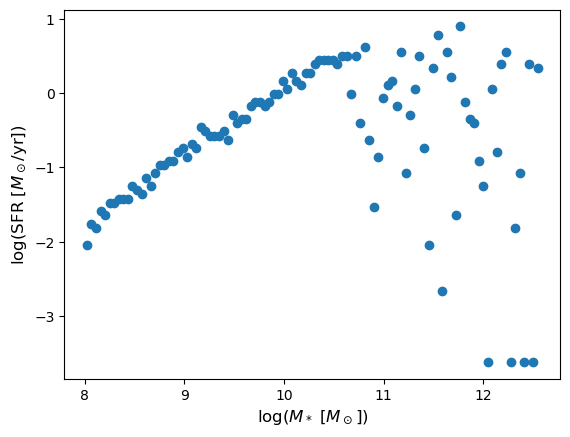

In [19]:
#let's check if the modes that were found are reasonable

plt.scatter(fMs,fSFR)
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('log(SFR [$M_\odot$/yr])',fontsize=12)

Now, we want to fit a line to this plot.

First, impose reasonable limits overwhich the main sequence appear linear. Pull the values of fMs and fSFR where this is the case.

In [20]:
wh=np.nonzero((fMs>8.25) &(fMs<10.))
masked_fMs = fMs[wh]
masked_fSFR = fSFR[wh]

Next, define the equation for a line that we will be using with scipy's curve_fit routine (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

In [21]:
#define a function to fit to
def line(x,A,B): 
    return(A*x+B)

Use scipy.curve_fit to find the best-fit parameters to the line

In [24]:
popt, pcov = curve_fit(line, masked_fMs, masked_fSFR)
print(f"popt: {popt}, pcov: {pcov}")

popt: [ 0.90593258 -8.9771656 ], pcov: [[ 0.00064283 -0.00586231]
 [-0.00586231  0.05363131]]


Lastly, estimate the error of the slope from the covariance and print it.

In [23]:
perr = np.sqrt(np.diag(pcov))

slope=popt[0]
slopeerr=perr[0]
#print the main sequence slope
print('slope: ',slope)
print('error: ', slopeerr)

slope:  0.9059325796941917
error:  0.025354128385792863


## Plotting it all together

We will now plot this line over the log(SFR) vs. log(Ms) plane.

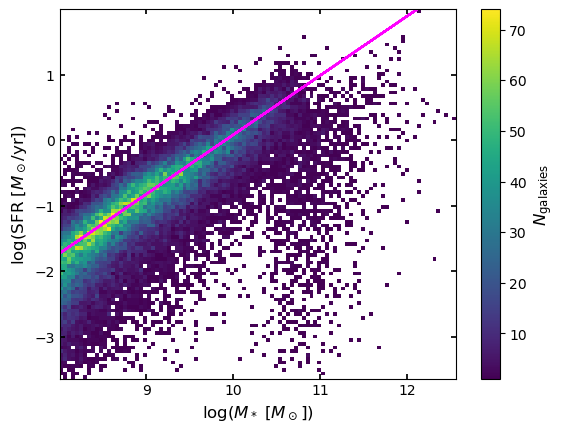

In [25]:
#Get the values of logmass and logSFR where logmass is finite.
#If you want, you can impose a fixed sSFR requirement. 
#A good choice is sSFR=10^-12
plt.hist2d(logmass[np.isfinite(logSFR)],\
           logSFR[np.isfinite(logSFR)], \
           bins=100, cmin=1)

#Plot the line that we fit
plt.plot(logmass, \
         line(logmass, *popt),\
         color='magenta')

#Add a colorbar and label it.
cbar=plt.colorbar()
cbar.set_label('$N_{\mathrm{galaxies}}$', rotation=90,fontsize=12)

#Label the figure axes
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('log(SFR [$M_\odot$/yr])',fontsize=12)

#Edit the tick labels
plt.tick_params(axis='both', direction='in', \
                width=1.25,labelsize='medium', \
                which='both',top=True,right=True)

## Exercise: Use a different calculation of stellar mass or SFR to test the impact on the resulting main sequence slope

So far, we have used instantaneous star formation rates. Let's try repeating this experiment using the star formation that has occurred in the past 10 Myrs.

We already defined SFR_10 above from the galaxy catalog that we made in Notebook 1. Notice that SFR_10 has the same shape as the instantaneous SFRs that we were using, there are just zero values where no star formation has taken place in the past 10 Myrs.

In [26]:
print(SFR_i.shape)
print(SFR_10.shape)

(49914,)
(49914,)


Now, let's define logSFR_10. We can use the same logMs array that we have been using, so we do not need to redefine that.

In [27]:
#ignore the runetimewarning.
logSFR_10 = np.log10(SFR_10)

/var/folders/9v/hlrr6pv51bv0wc4ddcq4b7d00000gn/T/ipykernel_52086/1970140623.py:2: RuntimeWarning: divide by zero encountered in log10
  logSFR_10 = np.log10(SFR_10)


In the block below, plot the logSFR_10 vs. logMs plane

The shape of hist is:  (100, 100)


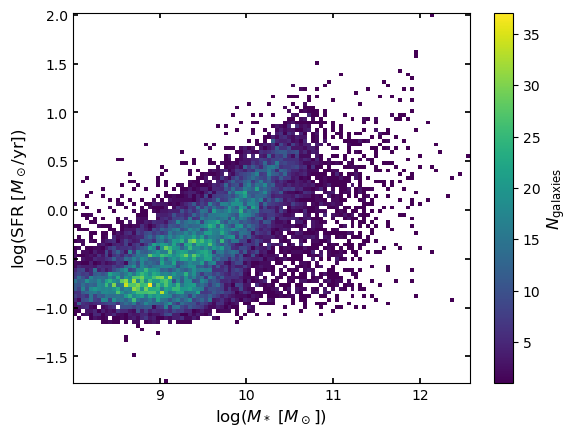

In [33]:
#Use hist2d to plot logSFR_10 vs logMs.
#Don't forget to either filter out the 
#non-finite SFRs or impose a fixed cutoff.

#Hint: copy the code for the first plot
#that we made and change
#logSFR to logSFR_10


hist, xedges, yedges, image = plt.hist2d(logmass[np.isfinite(logSFR_10)], \
                                         logSFR_10[np.isfinite(logSFR_10)], \
                                         bins=100, cmin=1)

print("The shape of hist is: ", hist.shape)

cbar=plt.colorbar()
cbar.set_label('$N_{\mathrm{galaxies}}$', rotation=90, fontsize=12)

#Label the axes
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('log(SFR [$M_\odot$/yr])',fontsize=12)

#Change the style of the tick marks
plt.tick_params(axis='both', direction='in', \
                width=1.25, labelsize='medium', \
                which='both', top=True, right=True)


Now, reference the code above and perform the ridge line fit to these data.

popt: [ 0.51229157 -5.2052677 ], pcov: [[ 0.00205994 -0.01878585]
 [-0.01878585  0.17186409]]
slope:  0.5122915670232829
error:  0.04538658746578059


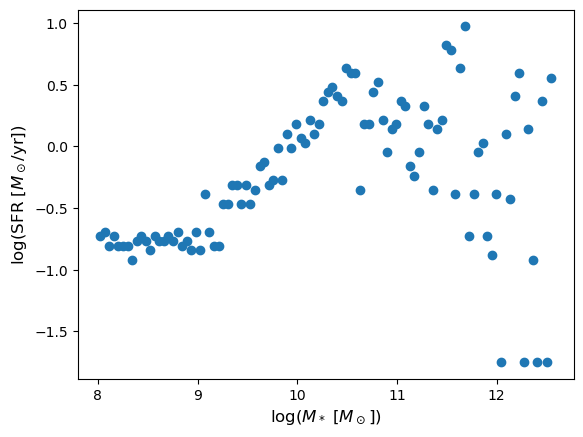

In [35]:
#Perform the ridge line fit to the new data below

fMs=np.empty(100)
fSFR=np.empty(100)

#find all NaN cells in hist
mask=np.isnan(hist)
#mask out the invalid cells
goodhist=ma.masked_array(hist, mask=mask)

for i in range(0, len(xedges)-1):
    fMs[i]=(xedges[i]+xedges[i+1])/2.
    hmax=np.argmax(goodhist[i,:])
    fSFR[i]=(yedges[hmax]+yedges[hmax+1])/2.

#let's check if the modes that were found are reasonable

plt.scatter(fMs,fSFR)
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('log(SFR [$M_\odot$/yr])',fontsize=12)


wh=np.nonzero((fMs>8.25) &(fMs<10.))
masked_fMs = fMs[wh]
masked_fSFR = fSFR[wh]


popt, pcov = curve_fit(line, masked_fMs, masked_fSFR)
print(f"popt: {popt}, pcov: {pcov}")

perr = np.sqrt(np.diag(pcov))

slope=popt[0]
slopeerr=perr[0]
#print the main sequence slope
print('slope: ',slope)
print('error: ', slopeerr)

Compare the slope of the line that you got here with the slope that we derived earlier. Are they statistically different?

Lastly, replot logSFR_10 vs. logMs and overlay the line that you just fit. How does this plot compare to the one that we made earler? 

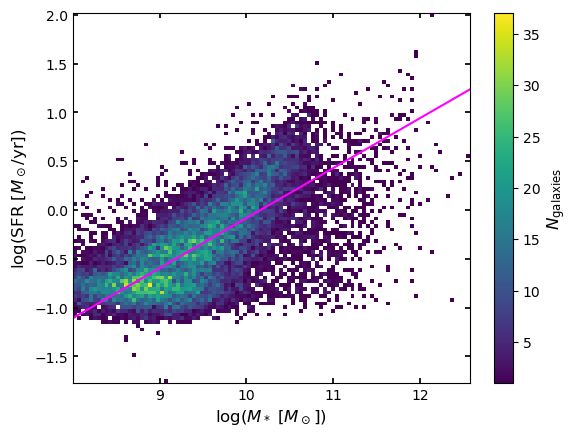

In [36]:
#Replot logSFR_10 vs. logMs with the
#line that you fit above.
#If you'd like, change the x and y limits of this plot
#to match the one that we made earlier.
#You can do this with plt.ylim(lower_bound, upper_bound)
#and plt.xlim(lower_bound, upper_bound)


plt.hist2d(logmass[np.isfinite(logSFR_10)],\
           logSFR_10[np.isfinite(logSFR_10)], \
           bins=100, cmin=1)

#Plot the line that we fit
plt.plot(logmass, \
         line(logmass, *popt),\
         color='magenta')

#Add a colorbar and label it.
cbar=plt.colorbar()
cbar.set_label('$N_{\mathrm{galaxies}}$', rotation=90,fontsize=12)

#Label the figure axes
plt.xlabel('log($M_*$ [$M_\odot$])',fontsize=12)
plt.ylabel('log(SFR [$M_\odot$/yr])',fontsize=12)

#Edit the tick labels
plt.tick_params(axis='both', direction='in', \
                width=1.25,labelsize='medium', \
                which='both',top=True,right=True)


## Extension: Explore the dependence of the SFMS on timescale or aperture

Going back to Notebook 1, the SFR supplementary catalog contains SFRs averaged over different timescales and within different apertures. You can add those to your galaxy catalog and follow the procedure above to find the main sequence slope. Then, you can explore the dependence of the slope on these choices. You can also check out the results in Donnari+ (2019): https://arxiv.org/abs/1812.07584 or Pillepich+ (2019): https://arxiv.org/abs/1902.05553.

In [37]:
### Extension ###

## Exercise: categorizing galaxies into star burst, main sequence, green valley, and quenched

The logSFR vs. logMs plane is often used to define different galaxy populations. These definitions usually categorize a galaxy as being a star burst, main sequence, green valley, or quench galaxy based on how far above or below the galaxy is from the main sequence ridge. 

In this exercise, you will classify galaxies based on the following definitions:

0. quenched: galSFR <= MS_SFR-1.1

1. green valley: MS_SFR-0.5 >= galSFR > MS_SFR-1.1

2. main sequence: MS_SFR+0.5 >= galSFR > MS_SFR-0.5

3. star burst: galSFR > MS_SFR.+0.5 
    
Here, galSFR is the star formation of a galaxy (in dex) and MS_SFR is the corresponding value of the SFR along the main sequence ridge (in dex).

In the following code block, you will define a function that takes in an arbitrary list of stellar masses and SFRs (each of length N) and outputs an array galClassification (length N) that classifies the galaxies into one of the above categories. That is, each galaxy will be assigned a number (either 0, 1, 2, or 3) based on its classification.

Let's do this using the total stellar masses and the instantaneous star formation rates. Earlier, we determined the ridge of the line going through these data had a slope of 0.9059 and a y-intercept of -8.977.

In [45]:
def SF_cat(galMs, galSFR, MS_slope, MS_inter):
    """
    Params
    --------
    galMs - (N,) - array of galaxy stellar masses (in dex), 
                   value must be finite.
    galSFR - (N,) - array of galaxy star formation rates (in dex),
                    value must be finite.
    MS_slope - int - slope of the main sequence ridge.
    MS_inter - int - intercept of the main sequence ridge.
    
    Returns
    --------
    galClass - (N,) - classification of each galaxy
                            either 0, 1, 2, or 3 corresponding to
                            quenched, green valley, main sequence,
                            or star burst, respectively.
                            
    """
    
    #instantiate classification
    galClass = np.empty(len(galMs))
    
    #Define the values of MS_SFR.
    #That is, the values of the main sequence ridge 
    #corresponding to the stellar masses that 
    #we are interested in
    
    MS_SFR = MS_slope * galMs + MS_inter
    #print(f"MS_SFR: {MS_SFR}")

    # Next, loop over each galaxy and classify it
    for i in range(len(galMs)):
        # Fill in the logic for each if statement
    
        if (galSFR[i] <= MS_SFR[i] - 1.1):#Fill in this logic
            galClass[i] = 0
            
        if (galSFR[i] > MS_SFR[i] - 1.1 and MS_SFR[i] - 0.5 >= galSFR[i]):#Fill in this logic
            galClass[i] = 1
            
        if (galSFR[i] > MS_SFR[i] - 0.5 and MS_SFR[i] + 0.5 >= galSFR[i]):#Fill in this logic
            galClass[i] = 2
            
        if (galSFR[i] > MS_SFR[i] + 0.5):#Fill in this logic
            galClass[i] = 3
            
    return galClass

Now, let's remove the non-finite values from logSFR and logmass and classify these galaxies using the relation that we calculated above.

In [46]:
#Remove non-finite values
finite_logmass = logmass[np.isfinite(logSFR)]
finite_logSFR = logSFR[np.isfinite(logSFR)]

In [47]:
#classify the galaxies

### Can update this code to replace the slope and intercept with the appropriate variables ####
galClass = SF_cat(finite_logmass, finite_logSFR, 0.9059, -8.977)

Let's see how many of each galaxy type we have in our sample.

In [48]:
print("There are ", len(finite_logSFR), " galaxies total")
print("There are ", len(galClass[galClass==0]), " quenched galaxies")
print("There are ", len(galClass[galClass==1]), " green valley galaxies")
print("There are ", len(galClass[galClass==2]), " main sequence galaxies")
print("There are ", len(galClass[galClass==3]), " star burst galaxies")

There are  35911  galaxies total
There are  2531  quenched galaxies
There are  5100  green valley galaxies
There are  27464  main sequence galaxies
There are  816  star burst galaxies


For reference, when the code was run for TNG100 with the default mass cut in Notebook 1, there were 35911 total galaxies, 2531 quenched galaxies, 5100 green valley galaxies, 15352 main sequence galaxies, and 12928 star burst galaxies.